In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
from Utility import data_collecter
import os
import lqr

/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [12]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
method_index = 4
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
# suffix = "DampingPendulum1_26"
# env_name = "DampingPendulum"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"
# suffix = "Reacher2_9"
# env_name = "Reacher-v2"
suffix = "TwoLinkRobot2_9"
env_name = "TwoLinkRobot"

In [13]:
method = Methods[method_index]
root_path = "../Data/"+suffix
print(method)
if method.endswith("KNonlinear"):
    import Learn_Knonlinear as lka
elif method.endswith("KNonlinearRNN"):
    import Learn_Knonlinear_RNN as lka
elif method.endswith("KoopmanNonlinear"):
    import Learn_KoopmanNonlinear_with_KlinearEig as lka
elif method.endswith("KoopmanNonlinearA"):
    import Learn_KoopmanNonlinearA_with_KlinearEig as lka
elif method.endswith("KoopmanU"):
    import Learn_Koopman_with_KlinearEig as lka
for file in os.listdir(root_path):
    if file.startswith(method+"_") and file.endswith(".pth"):
        model_path = file  
Data_collect = data_collecter(env_name)
udim = Data_collect.udim
Nstate = Data_collect.Nstates
layer_depth = 3
layer_width = 128
dicts = torch.load(root_path+"/"+model_path)
state_dict = dicts["model"]
if method.endswith("KNonlinear"):
    Elayer = dicts["Elayer"]
    net = lka.Network(layers=Elayer,u_dim=udim)
elif method.endswith("KNonlinearRNN"):
    net = lka.Network(input_size=udim+Nstate,output_size=Nstate,hidden_dim=layer_width, n_layers=layer_depth-1)
elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
    layer = dicts["layer"]
    blayer = dicts["blayer"]
    NKoopman = layer[-1]+Nstate
    net = lka.Network(layer,blayer,NKoopman,udim)
elif method.endswith("KoopmanU"):
    layer = dicts["layer"]
    NKoopman = layer[-1]+Nstate
    net = lka.Network(layer,NKoopman,udim)  
net.load_state_dict(state_dict)
device = torch.device("cpu")
net.cpu()
net.double()

KoopmanU


Network(
  (encode_net): Sequential(
    (linear_0): Linear(in_features=4, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=20, bias=True)
  )
  (lA): Linear(in_features=24, out_features=24, bias=False)
  (lB): Linear(in_features=2, out_features=24, bias=False)
)

In [35]:
def Psi_o(s,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    return psi

def Prepare_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = 0.001*np.eye(1)
        reset_state=  [0.0,0.0,-1.0,0.1]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-3.0,6.0]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 100*np.eye(1)
        reset_state = [-3.0,2.0]   
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-0.3,0.1]  
        x_ref[0] = 0.45
    elif env_name.startswith("Reacher"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[-3:-1,-3:-1] = 5*np.eye(2)
        # Q[-5:-3,-5:-3] = 0.01*np.eye(2)
        R = np.eye(2)
        x_ref[-1] = 0.01 #didn't change
        x_ref[-2] = 0.05
        x_ref[-3] = 0.15
        reset_state =None
    elif env_name.startswith("TwoLinkRobot"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[:2,:2] = 5*np.eye(2)
        Q[2:4,2:4] = 0.01*np.eye(2)
        R = np.eye(2)
        x_ref[0] = np.pi/2.0
        x_ref[1] = 0.0
        reset_state = [0,0,0,0]
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref

def criterion(env_name,observations):
    if env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
    elif env_name.startswith("Reacher"):
        err = np.mean(abs(observations[:,195:]-np.array([0]*6+[-0.05,0.05,0.01]).reshape(9,1)))
    elif env_name.startswith("TwoLinkRobot"):
        err = np.mean(abs(observations[:,195:]-np.array([np.pi/2.0,0.0,0,0]).reshape(-1,1)))
    return err

def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            loss += ucost[0,0]
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q),(observations[:,s]-x_ref))
        loss += xcost[0,0]
    return loss

0.0012221313779235167 2919.976314659765


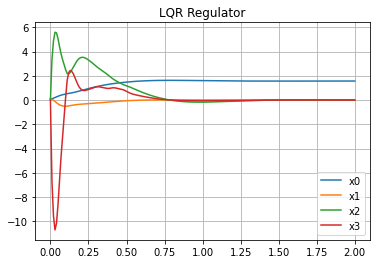

In [40]:
#Reacher-v2
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
env = Data_collect.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
reset_state=  [0.1,0.1,0.0,0.0]
uval = 0.0001 
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,uval*R)
observation_list = []
observation = env.reset_state(reset_state)
# observation = env.reset()
x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstate].reshape(-1,1))
u_list = []
steps = 200
for i in range(steps):
    u = -Kopt*(x0-x_ref_lift)
    # print(u.reshape(-1),'hh')
    observation, reward, done, info = env.step(u.reshape(-1))
    x0 = np.matrix(Psi_o(observation,net))
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)

observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
np.save("SingleControlResults/"+env_name+"_"+method+"_obs.npy",observations)
Err = criterion(env_name,observations)
loss = Cost(observations,u_list,Q[:Nstate,:Nstate],0.0001*R,x_ref)
print(Err,loss)
time_history = np.arange(steps+1)*env.dt
for i in range(4):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.savefig("SingleControlResults/"+env_name+"_"+method+".png")
plt.show()

In [11]:
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
env = Data_collect.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
# reset_state=  [0.0,0.0,-1.0,0.1]
uval = 0.01 
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,uval*R)
observation_list = []
observation = env.reset_state(reset_state)
x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstate].reshape(-1,1))
u_list = []
steps = 200
for i in range(steps):
    u = -Kopt*(x0-x_ref_lift)
    observation, reward, done, info = env.step(u[0,0])
    x0 = np.matrix(Psi_o(observation,net))
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)

observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
np.save("SingleControlResults/"+env_name+"_"+method+"_obs.npy",observations)
Err = criterion(env_name,observations)
loss = Cost(observations,u_list,Q[:Nstate,:Nstate],uval*R,x_ref)
print(Err,loss)
time_history = np.arange(steps+1)*env.dt
for i in range(Nstate):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.savefig("SingleControlResults/"+env_name+"_"+method+".png")
plt.show()

UnboundLocalError: local variable 'reset_state' referenced before assignment